In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-17 21:34:59.505218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 21:35:03.108865: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-17 21:35:03.109030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


In [2]:
# !git clone https://github.com/EricMartinezIllamola/asl-global.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "asl-global/asl-global"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
tf.config.experimental.list_physical_devices()

2023-09-17 21:35:07.292628: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

2023-09-17 21:35:07.292680: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-17 21:35:07.292717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (89d8297f8993): /proc/driver/nvidia/version does not exist


In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 4966 images belonging to 34 classes.
Found 1048 images belonging to 34 classes.
Found 1088 images belonging to 34 classes.


In [10]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-17 21:35:07.977169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
##DEFINIMOS EL MODELO
num_classes = 34
epochs = 70

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [12]:
## EJECUCION DEL MODELO
# with tf.device("/CPU:0"):
# with tf.device("/GPU:0"):
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-00', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/70
156/156 [==============================] - ETA: 0s - loss: 8.6565 - accuracy: 0.0362
Epoch 1: accuracy improved from -inf to 0.03625, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 698ms/step - loss: 8.6565 - accuracy: 0.0362 - lr: 0.0010
Epoch 2/70
156/156 [==============================] - ETA: 0s - loss: 8.3123 - accuracy: 0.0846
Epoch 2: accuracy improved from 0.03625 to 0.08458, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 698ms/step - loss: 8.3123 - accuracy: 0.0846 - lr: 0.0010
Epoch 3/70
156/156 [==============================] - ETA: 0s - loss: 8.0070 - accuracy: 0.1333
Epoch 3: accuracy improved from 0.08458 to 0.13331, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 700ms/step - loss: 8.0070 - accuracy: 0.1333 - lr: 0.0010
Epoch 4/70
156/156 [==============================] - ETA: 0s - loss: 7.6823 - accuracy: 0.2141
Epoch 4: accuracy improved from 0.13331 to 0.21406, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 701ms/step - loss: 7.6823 - accuracy: 0.2141 - lr: 0.0010
Epoch 5/70
156/156 [==============================] - ETA: 0s - loss: 7.3354 - accuracy: 0.2928
Epoch 5: accuracy improved from 0.21406 to 0.29279, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 697ms/step - loss: 7.3354 - accuracy: 0.2928 - lr: 0.0010
Epoch 6/70
156/156 [==============================] - ETA: 0s - loss: 6.9787 - accuracy: 0.3772
Epoch 6: accuracy improved from 0.29279 to 0.37716, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 702ms/step - loss: 6.9787 - accuracy: 0.3772 - lr: 0.0010
Epoch 7/70
156/156 [==============================] - ETA: 0s - loss: 6.7212 - accuracy: 0.4434
Epoch 7: accuracy improved from 0.37716 to 0.44342, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 108s 692ms/step - loss: 6.7212 - accuracy: 0.4434 - lr: 0.0010
Epoch 8/70
156/156 [==============================] - ETA: 0s - loss: 6.4387 - accuracy: 0.5197
Epoch 8: accuracy improved from 0.44342 to 0.51973, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 701ms/step - loss: 6.4387 - accuracy: 0.5197 - lr: 0.0010
Epoch 9/70
156/156 [==============================] - ETA: 0s - loss: 6.2211 - accuracy: 0.5789
Epoch 9: accuracy improved from 0.51973 to 0.57894, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 108s 690ms/step - loss: 6.2211 - accuracy: 0.5789 - lr: 0.0010
Epoch 10/70
156/156 [==============================] - ETA: 0s - loss: 6.0609 - accuracy: 0.6114
Epoch 10: accuracy improved from 0.57894 to 0.61136, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 107s 688ms/step - loss: 6.0609 - accuracy: 0.6114 - lr: 0.0010
Epoch 11/70
156/156 [==============================] - ETA: 0s - loss: 5.8964 - accuracy: 0.6587
Epoch 11: accuracy improved from 0.61136 to 0.65868, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 114s 733ms/step - loss: 5.8964 - accuracy: 0.6587 - lr: 0.0010
Epoch 12/70
156/156 [==============================] - ETA: 0s - loss: 5.7720 - accuracy: 0.6861
Epoch 12: accuracy improved from 0.65868 to 0.68607, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 238s 2s/step - loss: 5.7720 - accuracy: 0.6861 - lr: 0.0010
Epoch 13/70
156/156 [==============================] - ETA: 0s - loss: 5.6479 - accuracy: 0.7215
Epoch 13: accuracy improved from 0.68607 to 0.72151, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 197s 1s/step - loss: 5.6479 - accuracy: 0.7215 - lr: 0.0010
Epoch 14/70
156/156 [==============================] - ETA: 0s - loss: 5.5639 - accuracy: 0.7263
Epoch 14: accuracy improved from 0.72151 to 0.72634, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 704ms/step - loss: 5.5639 - accuracy: 0.7263 - lr: 0.0010
Epoch 15/70
156/156 [==============================] - ETA: 0s - loss: 5.4482 - accuracy: 0.7557
Epoch 15: accuracy improved from 0.72634 to 0.75574, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 111s 709ms/step - loss: 5.4482 - accuracy: 0.7557 - lr: 0.0010
Epoch 16/70
156/156 [==============================] - ETA: 0s - loss: 5.3699 - accuracy: 0.7747
Epoch 16: accuracy improved from 0.75574 to 0.77467, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 108s 693ms/step - loss: 5.3699 - accuracy: 0.7747 - lr: 0.0010
Epoch 17/70
156/156 [==============================] - ETA: 0s - loss: 5.2966 - accuracy: 0.7908
Epoch 17: accuracy improved from 0.77467 to 0.79078, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 703ms/step - loss: 5.2966 - accuracy: 0.7908 - lr: 0.0010
Epoch 18/70
156/156 [==============================] - ETA: 0s - loss: 5.2287 - accuracy: 0.7996
Epoch 18: accuracy improved from 0.79078 to 0.79964, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 704ms/step - loss: 5.2287 - accuracy: 0.7996 - lr: 0.0010
Epoch 19/70
156/156 [==============================] - ETA: 0s - loss: 5.1523 - accuracy: 0.8129
Epoch 19: accuracy improved from 0.79964 to 0.81293, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 707ms/step - loss: 5.1523 - accuracy: 0.8129 - lr: 0.0010
Epoch 20/70
156/156 [==============================] - ETA: 0s - loss: 5.0905 - accuracy: 0.8218
Epoch 20: accuracy improved from 0.81293 to 0.82179, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 698ms/step - loss: 5.0905 - accuracy: 0.8218 - lr: 0.0010
Epoch 21/70
156/156 [==============================] - ETA: 0s - loss: 5.0263 - accuracy: 0.8367
Epoch 21: accuracy improved from 0.82179 to 0.83669, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 705ms/step - loss: 5.0263 - accuracy: 0.8367 - lr: 0.0010
Epoch 22/70
156/156 [==============================] - ETA: 0s - loss: 4.9894 - accuracy: 0.8419
Epoch 22: accuracy improved from 0.83669 to 0.84193, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 111s 708ms/step - loss: 4.9894 - accuracy: 0.8419 - lr: 0.0010
Epoch 23/70
156/156 [==============================] - ETA: 0s - loss: 4.9360 - accuracy: 0.8462
Epoch 23: accuracy improved from 0.84193 to 0.84615, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 696ms/step - loss: 4.9360 - accuracy: 0.8462 - lr: 0.0010
Epoch 24/70
156/156 [==============================] - ETA: 0s - loss: 4.9027 - accuracy: 0.8488
Epoch 24: accuracy improved from 0.84615 to 0.84877, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 108s 695ms/step - loss: 4.9027 - accuracy: 0.8488 - lr: 0.0010
Epoch 25/70
156/156 [==============================] - ETA: 0s - loss: 4.8531 - accuracy: 0.8494
Epoch 25: accuracy improved from 0.84877 to 0.84938, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 697ms/step - loss: 4.8531 - accuracy: 0.8494 - lr: 0.0010
Epoch 26/70
156/156 [==============================] - ETA: 0s - loss: 4.7993 - accuracy: 0.8619
Epoch 26: accuracy improved from 0.84938 to 0.86186, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 700ms/step - loss: 4.7993 - accuracy: 0.8619 - lr: 0.0010
Epoch 27/70
156/156 [==============================] - ETA: 0s - loss: 4.7797 - accuracy: 0.8600
Epoch 27: accuracy did not improve from 0.86186
156/156 [==============================] - 103s 663ms/step - loss: 4.7797 - accuracy: 0.8600 - lr: 0.0010
Epoch 28/70
156/156 [==============================] - ETA: 0s - loss: 4.7212 - accuracy: 0.8709
Epoch 28: accuracy improved from 0.86186 to 0.87092, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 696ms/step - loss: 4.7212 - accuracy: 0.8709 - lr: 0.0010
Epoch 29/70
156/156 [==============================] - ETA: 0s - loss: 4.6884 - accuracy: 0.8760
Epoch 29: accuracy improved from 0.87092 to 0.87596, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 111s 709ms/step - loss: 4.6884 - accuracy: 0.8760 - lr: 0.0010
Epoch 30/70
156/156 [==============================] - ETA: 0s - loss: 4.6367 - accuracy: 0.8820
Epoch 30: accuracy improved from 0.87596 to 0.88200, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 702ms/step - loss: 4.6367 - accuracy: 0.8820 - lr: 0.0010
Epoch 31/70
156/156 [==============================] - ETA: 0s - loss: 4.6035 - accuracy: 0.8850
Epoch 31: accuracy improved from 0.88200 to 0.88502, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 108s 694ms/step - loss: 4.6035 - accuracy: 0.8850 - lr: 0.0010
Epoch 32/70
156/156 [==============================] - ETA: 0s - loss: 4.5758 - accuracy: 0.8832
Epoch 32: accuracy did not improve from 0.88502
156/156 [==============================] - 105s 674ms/step - loss: 4.5758 - accuracy: 0.8832 - lr: 0.0010
Epoch 33/70
156/156 [==============================] - ETA: 0s - loss: 4.5402 - accuracy: 0.8858
Epoch 33: accuracy improved from 0.88502 to 0.88582, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 701ms/step - loss: 4.5402 - accuracy: 0.8858 - lr: 0.0010
Epoch 34/70
156/156 [==============================] - ETA: 0s - loss: 4.5031 - accuracy: 0.8896
Epoch 34: accuracy improved from 0.88582 to 0.88965, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 108s 693ms/step - loss: 4.5031 - accuracy: 0.8896 - lr: 0.0010
Epoch 35/70
156/156 [==============================] - ETA: 0s - loss: 4.4479 - accuracy: 0.9029
Epoch 35: accuracy improved from 0.88965 to 0.90294, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 697ms/step - loss: 4.4479 - accuracy: 0.9029 - lr: 0.0010
Epoch 36/70
156/156 [==============================] - ETA: 0s - loss: 4.4256 - accuracy: 0.8979
Epoch 36: accuracy did not improve from 0.90294
156/156 [==============================] - 104s 664ms/step - loss: 4.4256 - accuracy: 0.8979 - lr: 0.0010
Epoch 37/70
156/156 [==============================] - ETA: 0s - loss: 4.3975 - accuracy: 0.8983
Epoch 37: accuracy did not improve from 0.90294
156/156 [==============================] - 105s 671ms/step - loss: 4.3975 - accuracy: 0.8983 - lr: 0.0010
Epoch 38/70
156/156 [==============================] - ETA: 0s - loss: 4.3578 - accuracy: 0.8995
Epoch 38: accuracy did not improve from 0.90294
156/156 [==============================] - 105s 672ms/step - loss: 4.3578 - accuracy: 0.8995 - lr: 0.0010
Epoch 39/70
156/156 [==============================] - ETA: 0s - loss: 4.3175 - accuracy: 0.9037
Epoch 39: accuracy improved from 0.90294 to 

INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 107s 683ms/step - loss: 4.3175 - accuracy: 0.9037 - lr: 0.0010
Epoch 40/70
156/156 [==============================] - ETA: 0s - loss: 4.3177 - accuracy: 0.8985
Epoch 40: accuracy did not improve from 0.90375
156/156 [==============================] - 103s 657ms/step - loss: 4.3177 - accuracy: 0.8985 - lr: 0.0010
Epoch 41/70
156/156 [==============================] - ETA: 0s - loss: 4.2633 - accuracy: 0.9078
Epoch 41: accuracy improved from 0.90375 to 0.90777, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 107s 687ms/step - loss: 4.2633 - accuracy: 0.9078 - lr: 0.0010
Epoch 42/70
156/156 [==============================] - ETA: 0s - loss: 4.2084 - accuracy: 0.9150
Epoch 42: accuracy improved from 0.90777 to 0.91502, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 107s 687ms/step - loss: 4.2084 - accuracy: 0.9150 - lr: 0.0010
Epoch 43/70
156/156 [==============================] - ETA: 0s - loss: 4.1922 - accuracy: 0.9178
Epoch 43: accuracy improved from 0.91502 to 0.91784, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 108s 691ms/step - loss: 4.1922 - accuracy: 0.9178 - lr: 0.0010
Epoch 44/70
156/156 [==============================] - ETA: 0s - loss: 4.1749 - accuracy: 0.9146
Epoch 44: accuracy did not improve from 0.91784
156/156 [==============================] - 104s 666ms/step - loss: 4.1749 - accuracy: 0.9146 - lr: 0.0010
Epoch 45/70
156/156 [==============================] - ETA: 0s - loss: 4.1406 - accuracy: 0.9217
Epoch 45: accuracy improved from 0.91784 to 0.92167, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 700ms/step - loss: 4.1406 - accuracy: 0.9217 - lr: 0.0010
Epoch 46/70
156/156 [==============================] - ETA: 0s - loss: 4.0968 - accuracy: 0.9253
Epoch 46: accuracy improved from 0.92167 to 0.92529, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 701ms/step - loss: 4.0968 - accuracy: 0.9253 - lr: 0.0010
Epoch 47/70
156/156 [==============================] - ETA: 0s - loss: 4.0892 - accuracy: 0.9184
Epoch 47: accuracy did not improve from 0.92529
156/156 [==============================] - 104s 665ms/step - loss: 4.0892 - accuracy: 0.9184 - lr: 0.0010
Epoch 48/70
156/156 [==============================] - ETA: 0s - loss: 4.0502 - accuracy: 0.9203
Epoch 48: accuracy did not improve from 0.92529
156/156 [==============================] - 103s 660ms/step - loss: 4.0502 - accuracy: 0.9203 - lr: 0.0010
Epoch 49/70
156/156 [==============================] - ETA: 0s - loss: 4.0254 - accuracy: 0.9283
Epoch 49: accuracy improved from 0.92529 to 0.92831, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 698ms/step - loss: 4.0254 - accuracy: 0.9283 - lr: 0.0010
Epoch 50/70
156/156 [==============================] - ETA: 0s - loss: 3.9905 - accuracy: 0.9253
Epoch 50: accuracy did not improve from 0.92831
156/156 [==============================] - 110s 704ms/step - loss: 3.9905 - accuracy: 0.9253 - lr: 0.0010
Epoch 51/70
156/156 [==============================] - ETA: 0s - loss: 3.9570 - accuracy: 0.9323
Epoch 51: accuracy improved from 0.92831 to 0.93234, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 113s 722ms/step - loss: 3.9570 - accuracy: 0.9323 - lr: 0.0010
Epoch 52/70
156/156 [==============================] - ETA: 0s - loss: 3.9352 - accuracy: 0.9265
Epoch 52: accuracy did not improve from 0.93234
156/156 [==============================] - 105s 670ms/step - loss: 3.9352 - accuracy: 0.9265 - lr: 0.0010
Epoch 53/70
156/156 [==============================] - ETA: 0s - loss: 3.9109 - accuracy: 0.9319
Epoch 53: accuracy did not improve from 0.93234
156/156 [==============================] - 106s 679ms/step - loss: 3.9109 - accuracy: 0.9319 - lr: 0.0010
Epoch 54/70
156/156 [==============================] - ETA: 0s - loss: 3.8867 - accuracy: 0.9327
Epoch 54: accuracy improved from 0.93234 to 0.93274, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 111s 709ms/step - loss: 3.8867 - accuracy: 0.9327 - lr: 0.0010
Epoch 55/70
156/156 [==============================] - ETA: 0s - loss: 3.8570 - accuracy: 0.9368
Epoch 55: accuracy improved from 0.93274 to 0.93677, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 109s 700ms/step - loss: 3.8570 - accuracy: 0.9368 - lr: 0.0010
Epoch 56/70
156/156 [==============================] - ETA: 0s - loss: 3.8353 - accuracy: 0.9305
Epoch 56: accuracy did not improve from 0.93677
156/156 [==============================] - 105s 674ms/step - loss: 3.8353 - accuracy: 0.9305 - lr: 0.0010
Epoch 57/70
156/156 [==============================] - ETA: 0s - loss: 3.8036 - accuracy: 0.9305
Epoch 57: accuracy did not improve from 0.93677
156/156 [==============================] - 104s 668ms/step - loss: 3.8036 - accuracy: 0.9305 - lr: 0.0010
Epoch 58/70
156/156 [==============================] - ETA: 0s - loss: 3.7754 - accuracy: 0.9335
Epoch 58: accuracy did not improve from 0.93677
156/156 [==============================] - 105s 672ms/step - loss: 3.7754 - accuracy: 0.9335 - lr: 0.0010
Epoch 59/70
156/156 [==============================] - ETA: 0s - loss: 3.7588 - accuracy: 0.9390
Epoch 59: accuracy improved from 0.93677 to 

INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 702ms/step - loss: 3.7588 - accuracy: 0.9390 - lr: 0.0010
Epoch 60/70
156/156 [==============================] - ETA: 0s - loss: 3.7186 - accuracy: 0.9414
Epoch 60: accuracy improved from 0.93899 to 0.94140, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 704ms/step - loss: 3.7186 - accuracy: 0.9414 - lr: 0.0010
Epoch 61/70
156/156 [==============================] - ETA: 0s - loss: 3.7118 - accuracy: 0.9356
Epoch 61: accuracy did not improve from 0.94140
156/156 [==============================] - 105s 674ms/step - loss: 3.7118 - accuracy: 0.9356 - lr: 0.0010
Epoch 62/70
156/156 [==============================] - ETA: 0s - loss: 3.6809 - accuracy: 0.9384
Epoch 62: accuracy did not improve from 0.94140
156/156 [==============================] - 106s 679ms/step - loss: 3.6809 - accuracy: 0.9384 - lr: 0.0010
Epoch 63/70
156/156 [==============================] - ETA: 0s - loss: 3.6500 - accuracy: 0.9448
Epoch 63: accuracy improved from 0.94140 to 0.94482, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 703ms/step - loss: 3.6500 - accuracy: 0.9448 - lr: 0.0010
Epoch 64/70
156/156 [==============================] - ETA: 0s - loss: 3.6190 - accuracy: 0.9466
Epoch 64: accuracy improved from 0.94482 to 0.94664, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 706ms/step - loss: 3.6190 - accuracy: 0.9466 - lr: 0.0010
Epoch 65/70
156/156 [==============================] - ETA: 0s - loss: 3.6176 - accuracy: 0.9380
Epoch 65: accuracy did not improve from 0.94664
156/156 [==============================] - 106s 679ms/step - loss: 3.6176 - accuracy: 0.9380 - lr: 0.0010
Epoch 66/70
156/156 [==============================] - ETA: 0s - loss: 3.5838 - accuracy: 0.9468
Epoch 66: accuracy improved from 0.94664 to 0.94684, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 112s 716ms/step - loss: 3.5838 - accuracy: 0.9468 - lr: 0.0010
Epoch 67/70
156/156 [==============================] - ETA: 0s - loss: 3.5730 - accuracy: 0.9428
Epoch 67: accuracy did not improve from 0.94684
156/156 [==============================] - 105s 669ms/step - loss: 3.5730 - accuracy: 0.9428 - lr: 0.0010
Epoch 68/70
156/156 [==============================] - ETA: 0s - loss: 3.5253 - accuracy: 0.9491
Epoch 68: accuracy improved from 0.94684 to 0.94905, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


156/156 [==============================] - 110s 704ms/step - loss: 3.5253 - accuracy: 0.9491 - lr: 0.0010
Epoch 69/70
156/156 [==============================] - ETA: 0s - loss: 3.5194 - accuracy: 0.9442
Epoch 69: accuracy did not improve from 0.94905
156/156 [==============================] - 104s 667ms/step - loss: 3.5194 - accuracy: 0.9442 - lr: 0.0010
Epoch 70/70
156/156 [==============================] - ETA: 0s - loss: 3.4950 - accuracy: 0.9482
Epoch 70: accuracy did not improve from 0.94905
156/156 [==============================] - 105s 670ms/step - loss: 3.4950 - accuracy: 0.9482 - lr: 0.0010


In [13]:
preds_test = model.predict(test_generator)

34/34 [==============================] - 6s 168ms/step


In [14]:
evaluate_test = model.evaluate(test_generator)

34/34 [==============================] - 6s 176ms/step - loss: 3.6317 - accuracy: 0.9136


In [15]:
evaluate_test

[3.6316606998443604, 0.9136029481887817]

In [16]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([ 0,  0,  0, ..., 33, 33, 33])

In [17]:
y_real_test = test_generator.classes
y_real_test

array([ 0,  0,  0, ..., 33, 33, 33], dtype=int32)

In [18]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9181985294117647

In [19]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[32,  0,  0, ...,  0,  0,  0],
       [ 0, 32,  0, ...,  0,  0,  0],
       [ 0,  0, 31, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 29,  0,  0],
       [ 0,  0,  0, ...,  1, 28,  0],
       [ 0,  0,  0, ...,  0,  0, 32]])

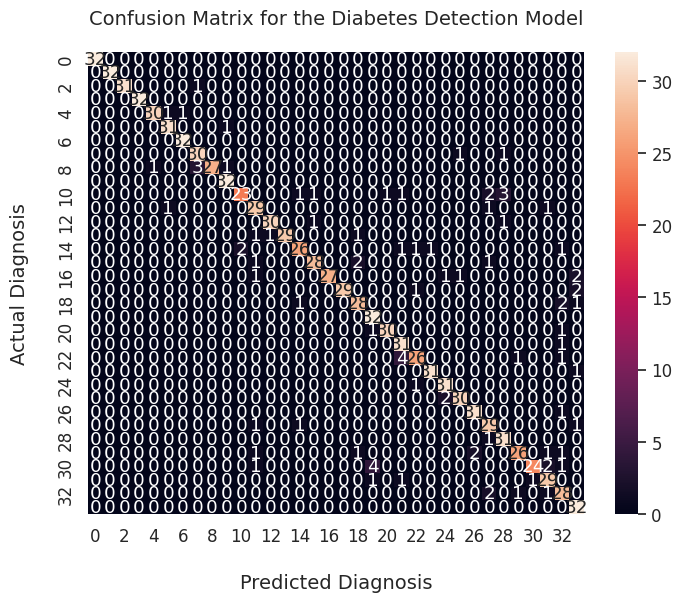

In [20]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [21]:
preds_val = model.predict(valid_generator)

33/33 [==============================] - 6s 171ms/step


In [22]:
evaluate_val = model.evaluate(valid_generator)

33/33 [==============================] - 6s 188ms/step - loss: 3.4999 - accuracy: 0.9408


In [23]:
evaluate_val

[3.4998583793640137, 0.9408397078514099]

In [24]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([ 0,  0,  0, ..., 33, 33, 33])

In [25]:
y_real_val = valid_generator.classes
y_real_val

array([ 0,  0,  0, ..., 33, 33, 33], dtype=int32)

In [26]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9456106870229007

In [27]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[30,  0,  0, ...,  0,  0,  0],
       [ 0, 30,  0, ...,  0,  0,  0],
       [ 0,  0, 28, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 30,  0,  0],
       [ 0,  0,  0, ...,  0, 28,  0],
       [ 0,  0,  0, ...,  0,  0, 31]])

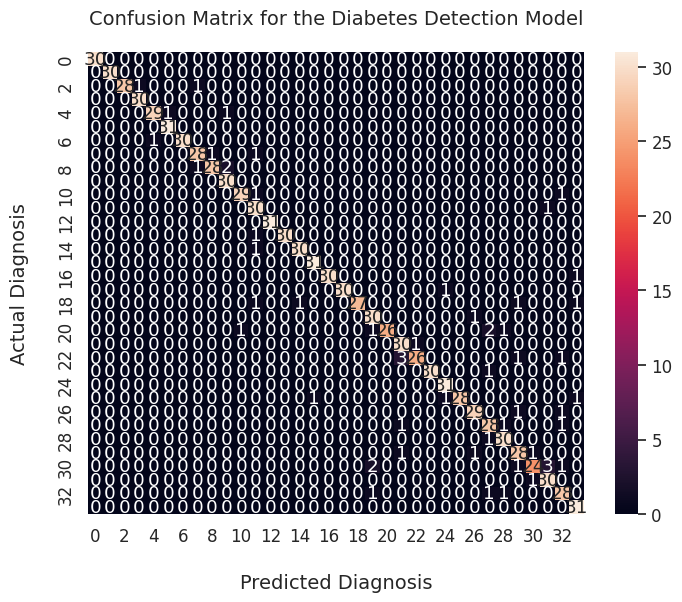

In [28]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()